#Import Libraries

In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

In [8]:
# Tối ưu mixed precision để tăng tốc
set_global_policy('mixed_float16')

In [2]:
import zipfile

zip_path = "/content/archive.zip"
extract_path = "/content/dataset"

# Giải nén
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Giải nén hoàn tất!")

Giải nén hoàn tất!


In [3]:
# Xem danh sách thư mục con trong thư mục dataset
print(os.listdir(extract_path))

['sports.csv', 'test', 'train', 'valid', 'EfficientNetB0-100-(224 X 224)- 98.40.h5']


In [9]:
# Định nghĩa tham số
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 16  # Giảm batch size để tăng tốc và ổn định
EPOCHS = 20  # Tăng epochs để học tốt hơn
DATASET_PATH = '/content/dataset'

In [10]:
# 1. Kiểm tra dữ liệu
train_path = os.path.join(DATASET_PATH, 'train')
valid_path = os.path.join(DATASET_PATH, 'valid')
test_path = os.path.join(DATASET_PATH, 'test')

print("Thư mục trong train:", os.listdir(train_path))
csv_path = os.path.join(DATASET_PATH, 'sports.csv')
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print("Nội dung sports.csv:\n", df.head())
    if 'class' in df.columns:
        print("Số lớp trong csv:", df['class'].nunique())

Thư mục trong train: ['tug of war', 'chuckwagon racing', 'surfing', 'motorcycle racing', 'ice climbing', 'ampute football', 'shot put', 'air hockey', 'figure skating men', 'archery', 'volleyball', 'steer wrestling', 'speed skating', 'jai alai', 'mushing', 'pommel horse', 'gaga', 'horse jumping', 'javelin', 'water polo', 'arm wrestling', 'hockey', 'parallel bar', 'hurdles', 'trapeze', 'hang gliding', 'sky surfing', 'pole vault', 'sumo wrestling', 'hammer throw', 'baton twirling', 'bmx', 'harness racing', 'disc golf', 'polo', 'rowing', 'frisbee', 'bike polo', 'table tennis', 'log rolling', 'horse racing', 'water cycling', 'cricket', 'cheerleading', 'rock climbing', 'football', 'bungee jumping', 'uneven bars', 'bobsled', 'rings', 'tennis', 'horseshoe pitching', 'weightlifting', 'nascar racing', 'barell racing', 'snow boarding', 'canoe slamon', 'lacrosse', 'rugby', 'track bicycle', 'bowling', 'pole climbing', 'basketball', 'jousting', 'wheelchair racing', 'snowmobile racing', 'golf', 'high

In [11]:
# 2. Chuẩn bị dữ liệu với augmentation mạnh hơn
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Tăng xoay
    width_shift_range=0.3,  # Tăng dịch chuyển
    height_shift_range=0.3,
    horizontal_flip=True,
    zoom_range=0.2,  # Thêm zoom
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Tính class weights để xử lý không cân bằng
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))

print("Số lớp:", train_generator.num_classes)
print("Số ảnh train:", train_generator.samples)
print("Số ảnh valid:", valid_generator.samples)
print("Số ảnh test:", test_generator.samples)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Số lớp: 100
Số ảnh train: 13492
Số ảnh valid: 500
Số ảnh test: 500


Hiển thị 6 ảnh mẫu từ tập train:
Found 13492 images belonging to 100 classes.


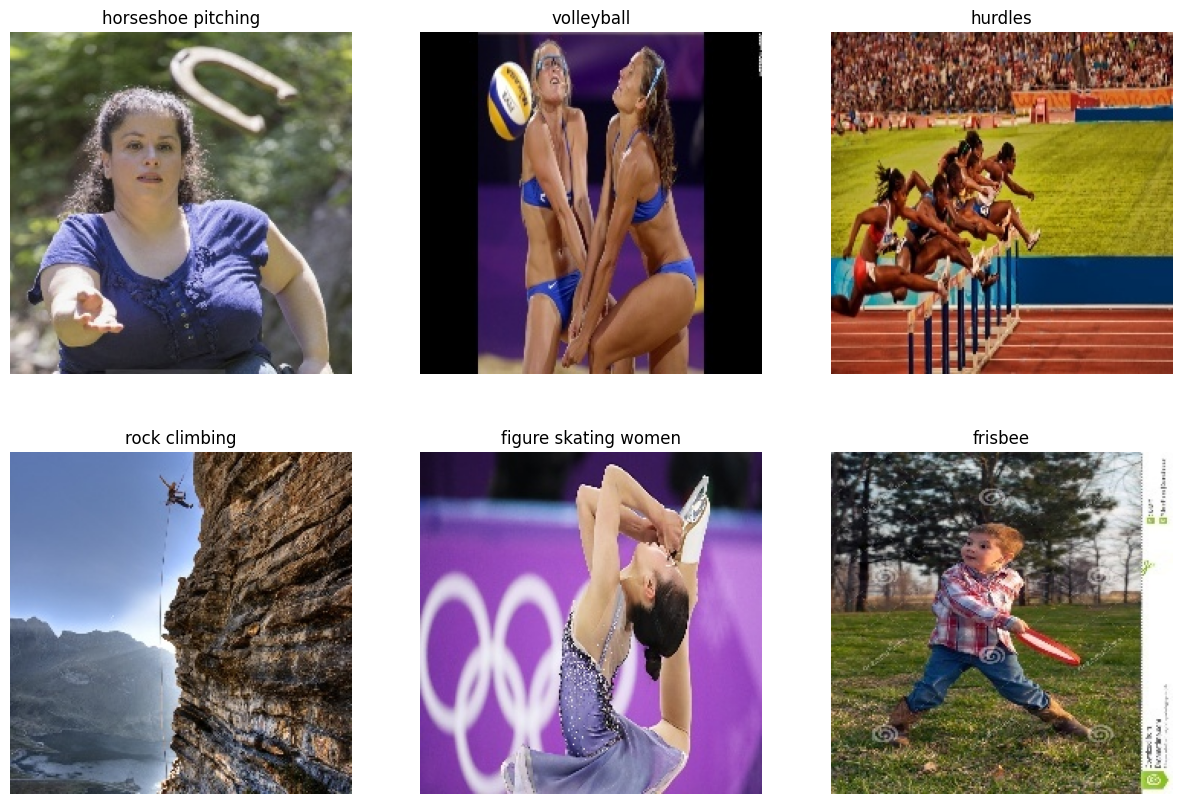

In [12]:
# 3. Hiển thị 6 ảnh mẫu từ tập train
print("Hiển thị 6 ảnh mẫu từ tập train:")
train_display_datagen = ImageDataGenerator(rescale=1./255)
train_display_generator = train_display_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=6,
    class_mode='categorical',
    shuffle=True
)
images, labels = next(train_display_generator)
class_names = list(train_display_generator.class_indices.keys())

plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    class_idx = np.argmax(labels[i])
    plt.title(class_names[class_idx])
    plt.axis('off')
plt.show()

In [13]:
# 4. Xây dựng mô hình MobileNetV2 với fine-tuning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True  # Cho phép fine-tune
for layer in base_model.layers[:-20]:  # Đóng băng trừ 20 tầng cuối
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax', dtype='float32')  # Mixed precision yêu cầu
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Giảm learning rate khi fine-tune
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,611,620 (9.96 MB)

 Trainable params: 1,559,716 (5.95 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

In [14]:
# 5. Huấn luyện mô hình
# history = model.fit(
#     train_generator,
#     epochs=EPOCHS,
#     validation_data=valid_generator
# )
# 5. Huấn luyện mô hình với Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 221s 236ms/step - accuracy: 0.0984 - loss: 4.1605 - val_accuracy: 0.6840 - val_loss: 1.2735
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 218s 198ms/step - accuracy: 0.4590 - loss: 2.1273 - val_accuracy: 0.8080 - val_loss: 0.6601
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 167s 197ms/step - accuracy: 0.6051 - loss: 1.5057 - val_accuracy: 0.8400 - val_loss: 0.5242
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 166s 196ms/step - accuracy: 0.6682 - loss: 1.2149 - val_accuracy: 0.8860 - val_loss: 0.3678
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 163s 193ms/step - accuracy: 0.7030 - loss: 1.0942 - val_accuracy: 0.8860 - val_loss: 0.3624
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 166s 196ms/step - accuracy: 0.7468 - loss: 0.9098 - val_accuracy: 0.9040 - val_loss: 0.3234
Epoch 7/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 163s 193ms/step - accuracy: 0.7686 - loss: 0.8360 - val_accuracy: 0.9080 - val_loss: 0.3011
Epoch 8/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 169s 200ms/step - accuracy: 0.7771 -

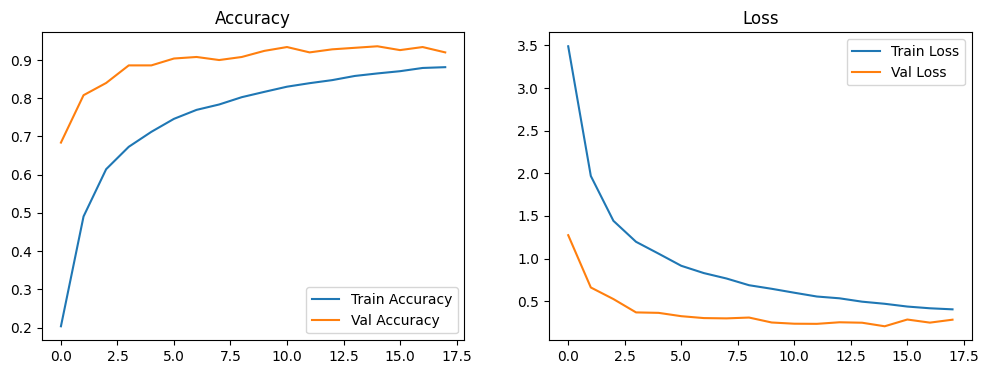

In [15]:
# 6. Vẽ biểu đồ accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [16]:
# 7. Đánh giá mô hình
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9448 - loss: 0.2118
Test Accuracy: 95.60%


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step


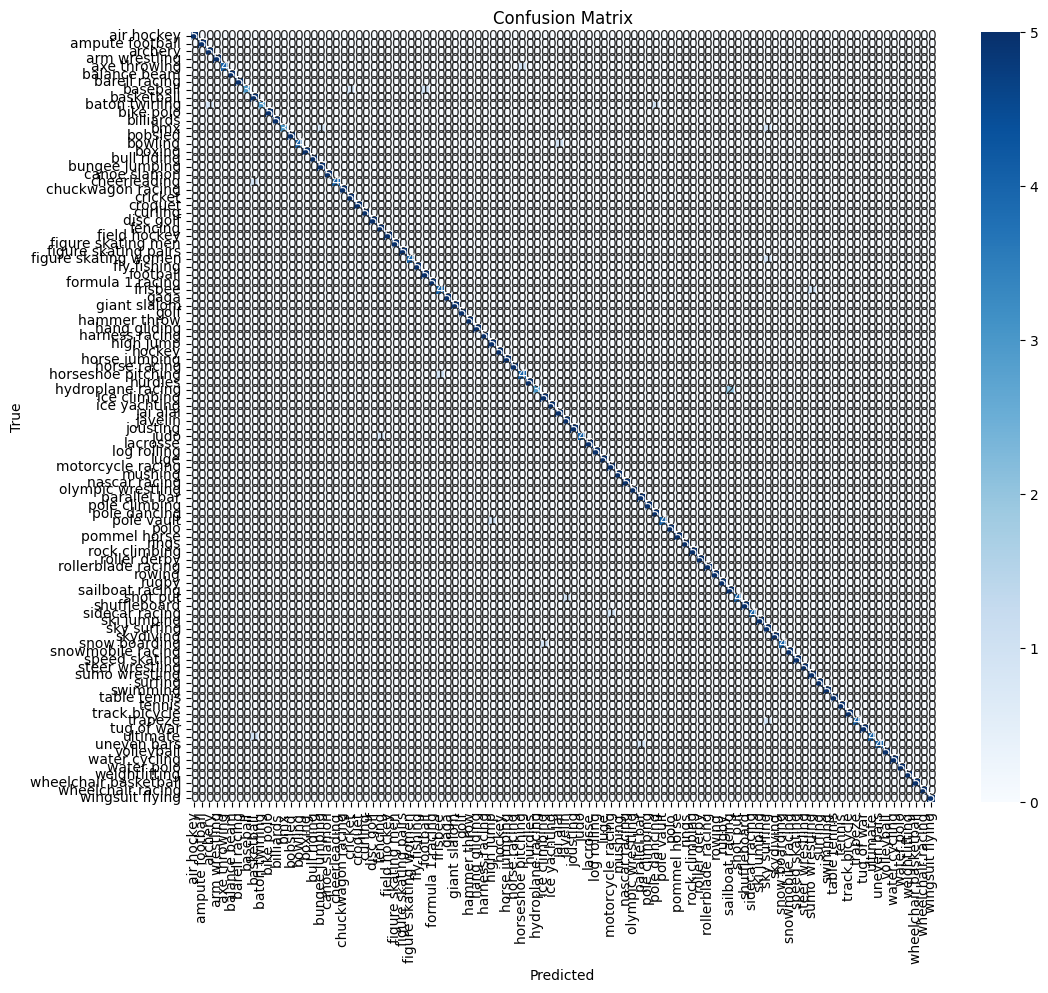

In [17]:
# Confusion matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

Classification Report:
                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       0.83      1.00      0.91         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      0.80      0.89         5
         balance beam       1.00      1.00      1.00         5
        barell racing       1.00      1.00      1.00         5
             baseball       1.00      0.60      0.75         5
           basketball       0.71      1.00      0.83         5
       baton twirling       1.00      0.60      0.75         5
            bike polo       1.00      1.00      1.00         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.60      0.75         5
              bobsled       1.00      1.00      1.00         5
              bowling       1.0

Hiển thị 6 ảnh mẫu từ tập test với nhãn thật và dự đoán:
Found 500 images belonging to 100 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


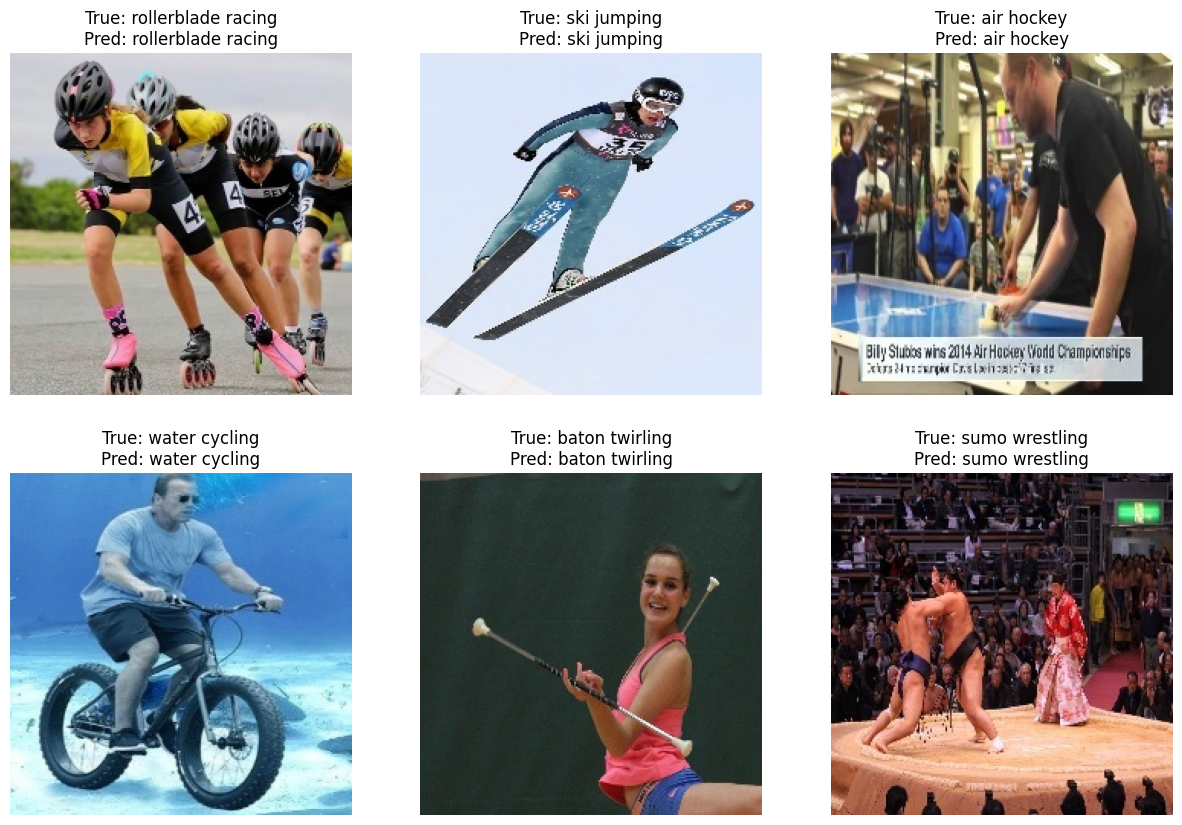

In [19]:
# 8. Hiển thị 6 ảnh mẫu từ tập test với nhãn thật và dự đoán
print("Hiển thị 6 ảnh mẫu từ tập test với nhãn thật và dự đoán:")
test_display_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=6,
    class_mode='categorical',
    shuffle=True
)
images, labels = next(test_display_generator)
predictions = model.predict(images)
pred_classes = np.argmax(predictions, axis=1)
class_names = list(test_display_generator.class_indices.keys())

plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    true_label = class_names[np.argmax(labels[i])]
    pred_label = class_names[pred_classes[i]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.show()